<h1><center><font size="6">Santander EDA, PCA and Light GBM Classification Model</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg"></img>

<br>
<b>
In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem. 
The data is anonimyzed, each row containing 200 numerical values identified just with a number.</b>

<b>Inspired by Jiwei Liu's Kernel. I added Data Augmentation Segment to my kernel</b>

### I will not be covering EDA in this kernel . I'd keep it short as the data is completely anonimized and all columns are just pure numbers, giving almost no insight . 
https://www.kaggle.com/roydatascience/eda-pca-lgbm-santander-transactions  You can check for EDA here

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

['train.csv', 'test.csv', 'sample_submission.csv']


In [2]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [4]:
print("Total values in the dataset : {}".format(df_train['target'].count()))
Ones = df_train.groupby('target')['target'].count()
print("% of 1s in total {}".format(Ones[1]*100.0/200000))

Total values in the dataset : 200000
% of 1s in total 10.049


## As one can see , there is a class imbalance. 
### Now , how do we solve it ? 

### Plan 1 : Oversampling / Undersampling -> 
* In this strategy , we either increase or decrease the number of samples by duplicating the smaller class or removing the majority class elements to make them equal or similar
* The risk involved is that we may change the original distribution of the data . 

### Plan 2 : Follow below ----->

This is how we filter using masks 

In [5]:
# Using the mask to filter out 1s . 
y = df_train['target']
y.head()
x = df_train[y > 0].copy()
x.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
13,train_13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,1.1064,8.6978,2.3287,-11.3409,13.7999,2.7925,6.3182,14.7313,7.2594,-2.4759,14.3984,9.1793,16.8467,19.4258,1.6565,2.5107,7.1272,13.6444,-12.8761,-1.0136,5.1773,7.3507,-16.0042,6.4460,-3.3238,14.3372,10.9481,6.7386,-0.5110,4.4335,...,32.5287,5.8451,4.9591,11.7805,-7.0936,11.8863,3.2597,-4.3478,7.5711,5.6656,3.5750,-8.6583,20.3131,-2.2723,15.7383,8.1730,-12.4963,15.1929,3.9751,8.5618,2.4566,9.3694,0.6942,11.9694,11.8982,0.6129,10.8123,-1.0803,11.9586,-0.5899,7.4002,7.4031,4.3989,4.0978,17.3638,-1.3022,9.6846,9.0419,15.6064,-10.8529
29,train_29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,1.2915,9.1168,6.8278,1.3898,14.0957,12.3335,9.0616,14.8726,11.3542,5.2004,1.6610,24.3097,3.1983,13.0446,4.3067,2.1315,7.9501,13.9981,-12.6789,-0.7712,5.9889,2.1959,-16.2435,10.9816,-3.2509,7.8550,11.2951,14.3999,2.3497,6.4171,...,11.6782,5.3495,5.1066,17.7215,-5.1919,19.0355,2.7651,-7.4054,6.3445,5.4183,8.6643,-10.3910,21.0844,4.1428,4.7056,8.5329,9.4661,9.6265,9.0617,4.3694,-1.1399,10.9190,-3.9144,8.1388,16.4554,4.7923,9.1281,-21.7322,18.6375,0.1734,5.9215,7.9676,2.3405,1.1482,23.2168,-2.0105,3.7600,9.4513,17.4105,-14.6897
63,train_63,1,7.7072,0.0183,9.9974,8.3524,9.2886,-13.3627,6.0425,10.1108,1.3999,6.6710,-5.1448,11.0835,14.0503,9.0144,8.8346,14.8138,5.0951,-1.6585,-2.3445,24.4873,9.4153,23.5101,9.3373,2.1534,11.1901,13.2911,-5.2299,-2.5387,4.1148,9.1110,-14.6391,12.8946,-0.9446,6.1225,10.8937,6.4271,0.7646,7.0633,...,22.5924,5.3977,3.3740,13.0953,3.0745,16.6974,2.0576,5.5558,3.1795,6.0669,2.5841,7.0790,13.1299,2.2445,23.1283,8.9796,-13.6216,10.5579,6.9716,2.9384,-7.2040,9.7592,15.1720,5.2335,27.6213,-9.2779,5.1130,-13.0577,10.0679,1.9046,1.5832,5.0039,3.8814,7.4241,21.4844,-0.8297,-3.0468,7.5790,15.7685,5.4769
65,train_65,1,10.5358,-2.5439,8.7394,6.7548,14.4099,-3.8724,5.1584,15.8381,5.8204,9.0358,-10.7504,7.7587,13.6021,4.2864,8.1159,14.0805,5.1303,4.0575,13.8723,16.9321,14.0983,2.2106,3.9192,2.8896,9.2493,13.5054,-0.4275,-3.2016,6.9686,0.8920,-16.6872,12.0119,0.8354,13.6590,11.7710,8.6702,2.3624,6.5731,...,25.3377,5.8066,5.2234,11.3098,-6.7546,30.5059,2.6117,-3.3249,4.7747,6.1149,2.2550,-0.5348,4.5535,-7.2104,19.7545,9.1091,-0.4833,13.7686,3.8680,6.3190,0.9670,12.9782,2.5409,13.7491,11.9410,2.8503,8.2088,-4.6266,10.2542,1.5517,4.6648,6.4227,3.4025,-4.0882,14.1174,-0.2472,5.3847,8.6949,15.1340,3.8449
71,train_71,1,6.7547,2.5973,14.2141,8.3514,7.4942,-1.3055,4.2336,15.0243,-1.8922,9.1282,-11.4237,-8.6036,13.9394,3.6480,5.0944,14.4429,9.2046,-4.3236,24.2658,13.5924,16.0715,33.3687,9.6420,2.2948,4.1684,13.3240,-2.8896,-3.2697,3.9168,4.3874,-7.1606,10.7617,-1.5133,7.8835,10.7454,9.3655,3.7260,4.6904,...,29.8664,5.7714,4.3278,15.8608,2.9925,13.3188,3.2917,-3.4176,6.6747,5.0565,11.9429,7.7473,8.6512,0.3140,20.4828,8.9715,-3.0613,12.5752,-14.9327,7.9488,9.3111,7.3559,3.7889,15.9203,11.2587,-0.7797,5.1381,6.1459,13.8773,-0.0899,1.4677,3.5935,2.0013,1.5777,18.2820,-4.3408,6.8869,9.3567,18.9013,13.3447


In [6]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [7]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 4,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    #"min_sum_hessian_in_leaf" : 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [9]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [10]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.883137	valid_1's auc: 0.872219
[2000]	training's auc: 0.895857	valid_1's auc: 0.882798
[3000]	training's auc: 0.90454	valid_1's auc: 0.889232
[4000]	training's auc: 0.910665	valid_1's auc: 0.893482
[5000]	training's auc: 0.91512	valid_1's auc: 0.89609
[6000]	training's auc: 0.9185	valid_1's auc: 0.897733
[7000]	training's auc: 0.921227	valid_1's auc: 0.898786
[8000]	training's auc: 0.923578	valid_1's auc: 0.899492
[9000]	training's auc: 0.925667	valid_1's auc: 0.899926
[10000]	training's auc: 0.927603	valid_1's auc: 0.900137
[11000]	training's auc: 0.92945	valid_1's auc: 0.900208
[12000]	training's auc: 0.93125	valid_1's auc: 0.900244
[13000]	training's auc: 0.932981	valid_1's auc: 0.900302
[14000]	training's auc: 0.934711	valid_1's auc: 0.900233
[15000]	training's auc: 0.93636	valid_1's auc: 0.90008
Early stopping, best iteration is:
[12902]	training's auc: 0.932822	valid_1's auc: 0.900321
Trainin

In [11]:
#%precision 3

# Let's see what this augmentation does to our data frame

In [12]:
print("Distribution of 1s in original data : {} / {} ".format(np.sum(y_train) , len(y_train)))
print("Percentage of 1s in original data : {}".format(np.sum(y_train)*100.0/len(y_train)))


print("Percentage of 1s in augmented data : {}".format(np.sum(y_t)*100.0/len(y_t)))
print("Distribution of 1s in augmented data : {} / {} ".format(np.sum(y_t) , len(y_t)))


Distribution of 1s in original data : 16079 / 160001 
Percentage of 1s in original data : 10.049312191798801
Percentage of 1s in augmented data : 14.352789952422183
Distribution of 1s in augmented data : 48237.0 / 336081 


## So How the augmentation was done ? 

    * X : Original  : 200,000
    * Xs : Ones     ~  20,000
    * Xn : Zeros    ~ 180,000  

    ### X_Final = X + 3\*Xs + 2\*Xn


Proof : ? 

1s = 20k(X) + 3\*20k(Xs) = 80k
Total = 20k(X) + 3\*20k(Xs) + 2\*180k(Xn)

i.e. , 
    80k / 520 k = 
    14.6 % (Approx. , the one we found above)

## Hence this technique is more like oversampling , but , here we oversample BOTH classses , rather than just one.      

In [13]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.901599772, std: 0.003074986. All auc: 0.901571645.


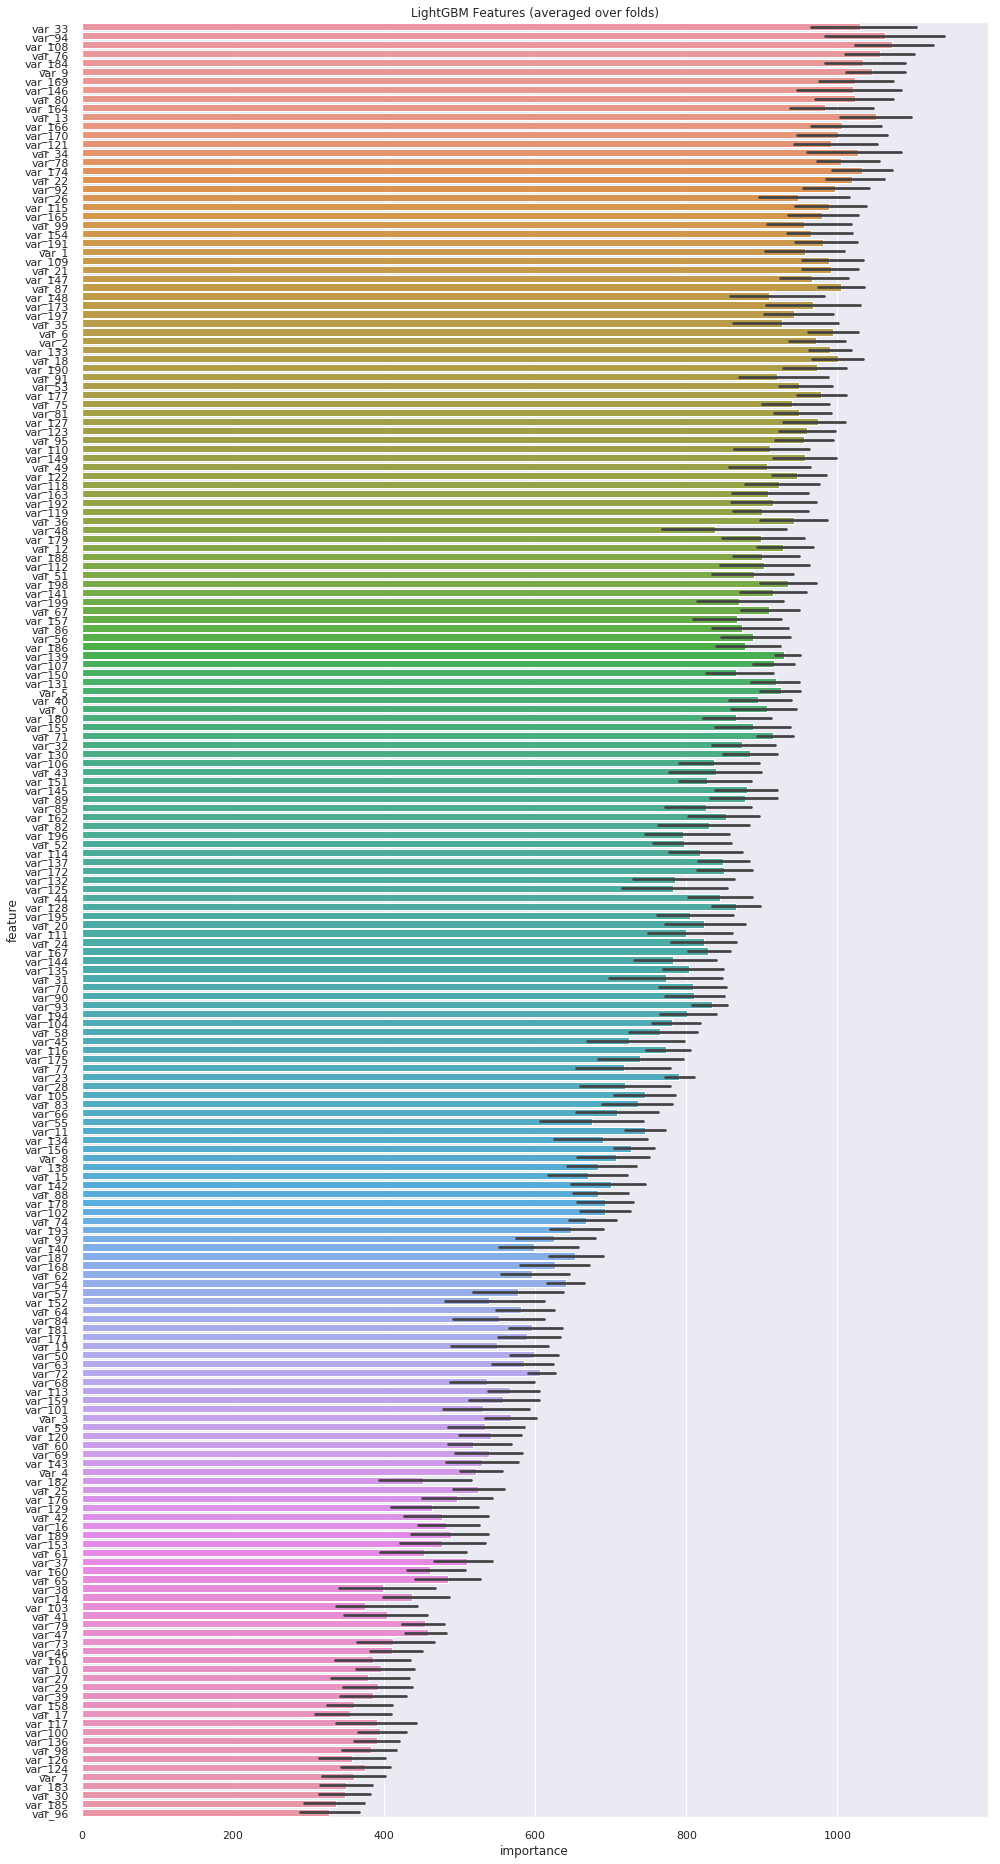

In [14]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [15]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)

## If you found this kernel useful , please upvote ><